# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

#### Determine Business Objectives

First thouroughly understand what the customer really wants to accomplish. In this case, a used car dealer would want to understand the determining factors that drive the price of a car. With this information, the dealer can appropriately price their cars to maximize their profits. In a different light, as someone who may be interested in buying a used car, I could glean information that would lead me to find a good car that I would regard as a worthwhile purchase.


In [1]:
#!pip install --upgrade pip
!pip install --user category_encoders

In [2]:
## Import Libraries

import pandas as pd
import numpy as np
import scipy as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import RFE
from sklearn import set_config
from sklearn.inspection import permutation_importance
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, ColumnTransformer, make_column_selector
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso, ARDRegression, BayesianRidge
from sklearn.kernel_ridge import KernelRidge 
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error, r2_score

import io
from sklearn.inspection import permutation_importance
#from ydata_profiling import ProfileReport
from category_encoders import TargetEncoder

In [3]:
#Import Data file
Vehicles = pd.read_csv('Data/vehicles.csv')
Vehicles.head(5)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [4]:
#Obtain information about the data set
Vehicles.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [5]:
Vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [6]:
Unique = Vehicles.nunique(axis = 0)
Unique

id              426880
region             404
price            15655
year               114
manufacturer        42
model            29649
condition            6
cylinders            8
fuel                 5
odometer        104870
title_status         6
transmission         3
VIN             118246
drive                3
size                 4
type                13
paint_color         12
state               51
dtype: int64

In [7]:
Vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [8]:
#Quantify Null values
Vehicles.isnull().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [9]:
#Drop unique value columns and other descriptors
Vehicles1 = Vehicles.drop(columns = ['id', 'VIN', 'size', 'paint_color', 'drive', 'region'])
Vehicles1.sample(10)

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,type,state
101460,23990,2015.0,gmc,canyon,excellent,6 cylinders,gas,79080.0,clean,automatic,pickup,fl
327948,49900,1979.0,jeep,cj-5,NaN,8 cylinders,gas,99500.0,clean,manual,SUV,pa
291660,0,2004.0,NaN,Oldsmobile Bravada,excellent,6 cylinders,gas,177632.0,clean,automatic,SUV,oh
276226,19990,2016.0,audi,a3 sportback e-tron premium,good,NaN,gas,67751.0,clean,other,wagon,ny
6120,20999,2014.0,bmw,528xi,NaN,NaN,gas,84300.0,clean,automatic,sedan,ak
125125,23990,2016.0,cadillac,cts 2.0 luxury,good,NaN,gas,40768.0,clean,other,sedan,ga
152877,32999,2012.0,chevrolet,silverado,NaN,NaN,diesel,186000.0,clean,automatic,NaN,in
122240,25000,2015.0,mercedes-benz,benz gl450,excellent,8 cylinders,gas,80333.0,clean,automatic,SUV,ga
140158,5995,2007.0,honda,accord lx,excellent,6 cylinders,gas,86817.0,clean,automatic,sedan,il
312102,34990,2001.0,ford,f-450,NaN,NaN,diesel,138288.0,clean,automatic,other,or


In [10]:
#Cleaning data and filling in values
Vehicles1['year'] = Vehicles1['year'].fillna(Vehicles1['year'].mode()[0])
Vehicles1['condition'] = Vehicles1['condition'].fillna(Vehicles1['condition'].mode()[0])
Vehicles1['cylinders'] = Vehicles1['cylinders'].str.replace(' cylinders', '')
Vehicles1['cylinders'] = Vehicles1['cylinders'].fillna(Vehicles1['cylinders'].mode()[0])
Vehicles1['cylinders'] = Vehicles1['cylinders'].str.replace('other', Vehicles1['cylinders'].mode()[0])
Vehicles1['cylinders'] = pd.to_numeric(Vehicles1['cylinders'])

Vehicles1['type'] = Vehicles1['type'].fillna('other')

In [11]:
Vehicles1.sample(5)

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,type,state
40250,31990,2018.0,volkswagen,atlas sel 4motion,good,6,gas,39214.0,clean,other,other,ca
246719,9995,2004.0,ford,f250,good,8,gas,153976.0,clean,automatic,pickup,nv
132639,22867,2017.0,honda,accord sedan,good,6,gas,22917.0,clean,automatic,sedan,id
354604,23989,2018.0,toyota,rav4,good,4,gas,30999.0,clean,automatic,SUV,tn
135036,0,1997.0,ram,2500,good,6,diesel,152947.0,clean,automatic,truck,id


In [12]:
Vehicles1.isnull().sum()

price               0
year                0
manufacturer    17646
model            5277
condition           0
cylinders           0
fuel             3013
odometer         4400
title_status     8242
transmission     2556
type                0
state               0
dtype: int64

In [13]:
Vehicles1.dropna(inplace = True)

In [14]:
Vehicles1.isnull().sum()

price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
type            0
state           0
dtype: int64

In [15]:
Vehicles1.insert(loc = 2, column = "age", value = 2025 - Vehicles1['year'])

In [16]:
Vehicles1.sample(100)

,price,year,age,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,type,state
303092,27990,2018.0,7.0,nissan,frontier crew cab pro-4x,good,6,gas,37332.0,clean,other,pickup,oh
135336,0,2017.0,8.0,chevrolet,camaro,good,8,gas,5910.0,clean,manual,coupe,id
227055,22998,2019.0,6.0,jeep,renegade,good,4,gas,18610.0,clean,automatic,SUV,mt
241493,8000,2012.0,13.0,honda,civic ex-l,good,4,gas,127000.0,clean,automatic,coupe,nc
32793,5200,2013.0,12.0,nissan,sentra sv,excellent,4,gas,156730.0,clean,automatic,sedan,ca
...,...,...,...,...,...,...,...,...,...,...,...,...,...
217701,0,2014.0,11.0,honda,accord sedan,good,6,gas,47664.0,clean,automatic,other,mn
390898,7255,2013.0,12.0,hyundai,elantra,good,6,gas,128300.0,clean,automatic,sedan,va
188624,31590,2013.0,12.0,ford,f150 supercrew cab fx4,good,6,other,68089.0,clean,other,pickup,ma
414500,17990,2009.0,16.0,pontiac,solstice convertible 2d,good,6,other,46210.0,clean,other,convertible,wv


In [17]:
Vehicles1.count()

price           389610
year            389610
age             389610
manufacturer    389610
model           389610
condition       389610
cylinders       389610
fuel            389610
odometer        389610
title_status    389610
transmission    389610
type            389610
state           389610
dtype: int64

#### Identifying Outliers

In [18]:
PriceVAge = Vehicles1[['price','age']]
#Vehicles1[['price','age']].hist(bins = 50, figsize = (10,8));
PriceVAge

,price,age
27,33590,11.0
28,22590,15.0
29,39590,5.0
30,30990,8.0
31,15000,12.0
...,...,...
426875,23590,6.0
426876,30590,5.0
426877,34990,5.0
426878,28990,7.0


<Axes: xlabel='price', ylabel='age'>

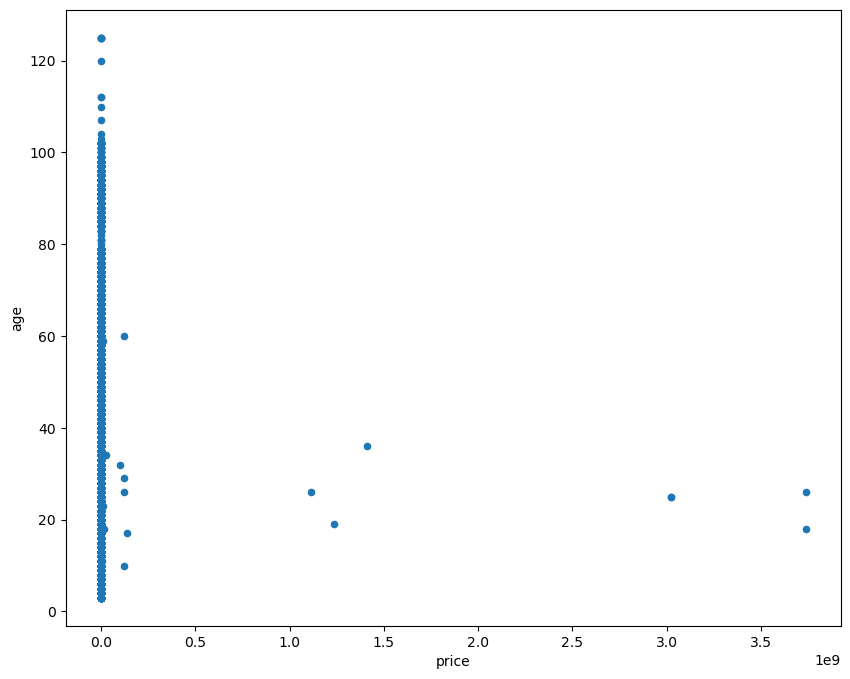

In [19]:
PriceVAge.plot(kind= 'scatter', x = 'price', y = 'age', figsize=(10,8))

In [20]:
def outliers_filter(Vehicles1, column):
    factor = 1.5
    first_quartile = Vehicles1[column].quantile(.25)
    third_quartile = Vehicles1[column].quantile(.75)
    iqr = third_quartile - first_quartile
    lower = first_quartile - factor*iqr
    upper = third_quartile + factor*iqr
    print( f' lower: { lower }, upper: { upper }')
    return

outliers_filter(Vehicles1, 'price')

lower = 250
upper = 75000
#Vehicles w/o outliers
VWO = Vehicles1.query( f'price > { lower } and price < { upper }' )

 lower: -24897.5, upper: 57482.5


<Axes: xlabel='price', ylabel='Count'>

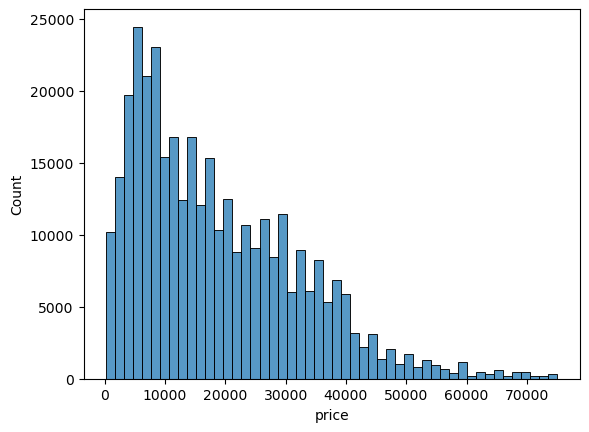

In [21]:
sns.histplot(VWO['price'], bins = 50)

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [22]:
results = []

In [23]:
# Split dataset into train and test set
X = VWO.drop('price', axis = 1)
y = VWO['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

features = X.columns
features

Index(['year', 'age', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'type', 'state'],
      dtype='object')

In [24]:
catcols = VWO.select_dtypes(include=object).columns
catcols

Index(['manufacturer', 'model', 'condition', 'fuel', 'title_status',
       'transmission', 'type', 'state'],
      dtype='object')

In [25]:
#Simple Linear Regression
TE = TargetEncoder()
encodedVWO = TE.fit_transform(VWO[features], VWO['price'])

X1 = encodedVWO
y1 = VWO['price']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = .2, random_state = 42)

V1_model = LinearRegression().fit(X1_train, y1_train)

pred_train = V1_model.predict(X1_train[features])
pred_test = V1_model.predict(X1_test[features])

train_mse = mean_squared_error(y_train, pred_train)
test_mse = mean_squared_error(y_test, pred_test)

train_r2 = r2_score(y_train, pred_train)
test_r2 = r2_score(y_test, pred_test)

linreg_results = {
    'Model': 'Linear Regression',
    'train_mse': train_mse,
    'test_mse': test_mse,
    'train_r2': train_r2,
    'test_r2': test_r2
}
results.append(linreg_results)

In [26]:
results

[{'Model': 'Linear Regression',
  'train_mse': 73208146.58629742,
  'test_mse': 73190964.0627472,
  'train_r2': 0.6100306981403214,
  'test_r2': 0.6066684759753591}]

In [33]:
#Polynomial Linear Regression

# Apply TargetEncoder before pipeline
encoder = ce.TargetEncoder(cols=catcols)
X1_train[catcols] = encoder.fit_transform(X1_train[catcols], y1_train)
X1_test[catcols] = encoder.transform(X1_test[catcols])

# Define column transformer (without TargetEncoder)
coltrans = make_column_transformer(
    ('poly', PolynomialFeatures(), make_column_selector(dtype_include=np.number))
)

# Define the pipeline
pipe = Pipeline([
    ('transformer', coltrans),
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])

# Correct hyperparameter grid
degree_dict = {'transformer__poly__degree': [1, 2, 3, 4, 5]}

# Run GridSearchCV
gscv = GridSearchCV(pipe, param_grid=degree_dict, cv=5)
gscv.fit(X1_train[features], y1_train)


ValueError: too many values to unpack (expected 2)

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.